In [1]:
import numpy as np
import audioflux as af
from audioflux.type import SpectralFilterBankScaleType
import math
from IPython.display import Audio, display, Image, HTML
import matplotlib.pyplot as plt
from audioflux.display import fill_spec
import PIL
from prototyping import *

In [2]:
def get_spectrogram(audio_arr):
    # Create BFT object and extract mel spectrogram
    bft_obj = af.BFT(num=128, radix2_exp=12, samplate=SAMPLE_RATE,
                     scale_type=SpectralFilterBankScaleType.MEL)

    spec_arr = bft_obj.bft(audio_arr)
    spec_arr = np.abs(spec_arr)
    return bft_obj, spec_arr

In [3]:
# class SineSource:
#     def __init__(self, frequency: float):
#         self.frequency = frequency
#         self.phase = 0.0
#         self.phase_diff = (2.0 * math.pi * frequency) / SAMPLE_RATE
    
#     def tick(self, modulation):
#         result = math.sin(self.phase + modulation)
#         self.phase += self.phase_diff
#         return result

# def play_synth(mod_mult, mod_strength):
#     source = SineSource(440)
#     modulator = SineSource(440 * mod_mult)

#     audio_arr = np.zeros(NUM_SAMPLES)
#     sr = SAMPLE_RATE

#     for i in range(NUM_SAMPLES):
#         # print("tick")
#         audio_arr[i] = source.tick(modulator.tick(0) * mod_strength)
#         # modulator.phase_diff += 0.00000001
#     return audio_arr

# audio_arr = play_synth(0.25, 2)


# bft_obj, spec_arr = get_spectrogram(audio_arr)

# audio_len = audio_arr.shape[-1]
# print(audio_len)

# fig, ax = plt.subplots()
# img = fill_spec(spec_arr, axes=ax,
#           x_coords=bft_obj.x_coords(audio_len),
#           y_coords=bft_obj.y_coords(),
#           x_axis='time', y_axis='log',
#           title='Mel Spectrogram')

# fig.colorbar(img, ax=ax)
# # plt.show()
# # print(spec_arr)

In [4]:
# from scipy.optimize import differential_evolution

# def target_fun(arg):
#     audio_arr = play_synth(arg[0], arg[1])
#     bft_obj, synth_spectrogram = get_spectrogram(audio_arr)

#     return abs(sum(sum(synth_spectrogram - sample_spectrogram)))
# # synth_spectrogram.shape

# def callback(xk, convergence):
#     print(xk)

# result = differential_evolution(target_fun, bounds=[ (-1, 2), (-1, 2)], callback=callback, popsize=20, maxiter=30, workers=8)
# result

In [5]:
# audio_arr = play_synth(result.x[0], result.x[1])

# bft_obj, spec_arr = get_spectrogram(audio_arr)

# audio_len = audio_arr.shape[-1]
# print(audio_len)

# fig, ax = plt.subplots()
# img = fill_spec(spec_arr, axes=ax,
#           x_coords=bft_obj.x_coords(audio_len),
#           y_coords=bft_obj.y_coords(),
#           x_axis='time', y_axis='log',
#           title='Mel Spectrogram')

# fig.colorbar(img, ax=ax)

In [6]:
# # bft_obj, target_arr = get_spectrogram(play_synth(0.25, 2))
# # bft_obj, spec_arr_2 = get_spectrogram(play_synth(0.25, 2))

# # abs(sum(sum(target_arr - spec_arr_2)))
# r = af.write("/tmp/test.wav", audio_arr, SAMPLE_RATE)
# # print(r)

# Audio(data=audio_arr, rate=SAMPLE_RATE)

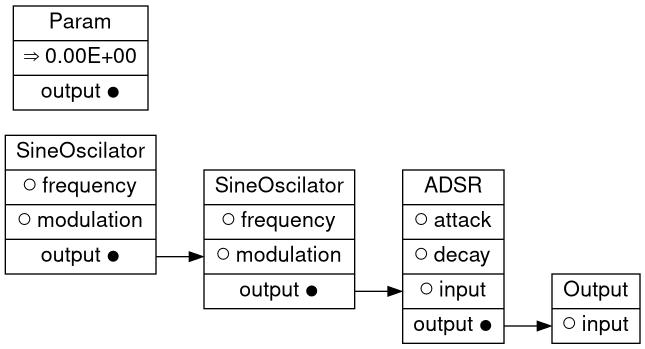

/home/wint3rmute/.cache/pypoetry/virtualenvs/luthier-F1mMpa_R-py3.10/lib/python3.10/site-packages/IPython/lib/display.py:187: RuntimeWarning: invalid value encountered in divide
  scaled = data / normalization_factor * 32767


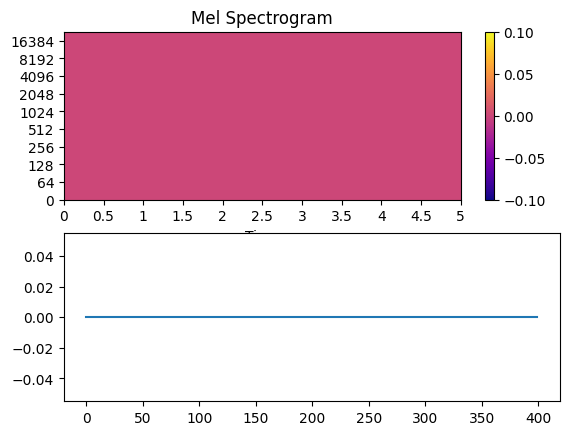

In [7]:
g = DspGraph()

sine_1 = g.add_node(SineOscilator())
sine_2 = g.add_node(SineOscilator())

adsr = g.add_node(ADSR())
# adsr2 = g.add_node(ADSR())

# sum = g.add_node(Sum())
output = g.add_node(Output())
source_1 = g.add_node(Param())
# source_2 = g.add_node(Param())
g.patch(adsr, "output", output, "input")

# g.nodes[sine_2].inputs.frequency = 440
# g.nodes[sine_1].inputs.frequency = 440 * 2.5

g.nodes[adsr].inputs.attack = 1
g.nodes[adsr].inputs.decay = 0.0000001

g.patch(sine_1, "output", sine_2, "modulation")
g.patch(sine_2, "output", adsr, "input")

# g.patch(source_1, "output", sine_2, "frequency")
# g.patch(source_2, "output", sine_1, "frequency")
# g.patch(sine_2, "output", sum, "in_1")
# g.patch(sine_1, "output", sum, "in_2")

# g.patch(sum, "out", output, "input")

audio_arr = np.zeros(SAMPLE_RATE * 5)

for i in range(len(audio_arr)):
    audio_arr[i] = (g.nodes[output].inputs.input)
    g.tick()
    # time.sleep(0.01)
    
# audio_arr
display(Image(g.draw()))

bft_obj, spec_arr = get_spectrogram(audio_arr)

audio_len = audio_arr.shape[-1]

fig, (ax, ax2) = plt.subplots(2, 1, sharex=False, sharey=False)
img = fill_spec(spec_arr, axes=ax,
          x_coords=bft_obj.x_coords(audio_len),
          y_coords=bft_obj.y_coords(),
          x_axis='time', y_axis='log',
          title='Mel Spectrogram')

fig.colorbar(img, ax=ax)

ax2.plot(audio_arr[:400])
display(Audio(data=audio_arr, rate=SAMPLE_RATE))

sum 10.075427743754995 0.7070818044018262


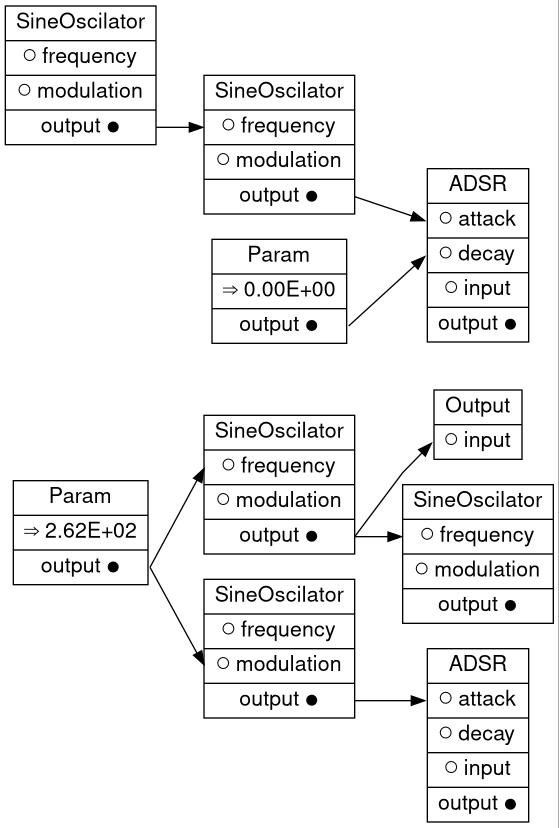

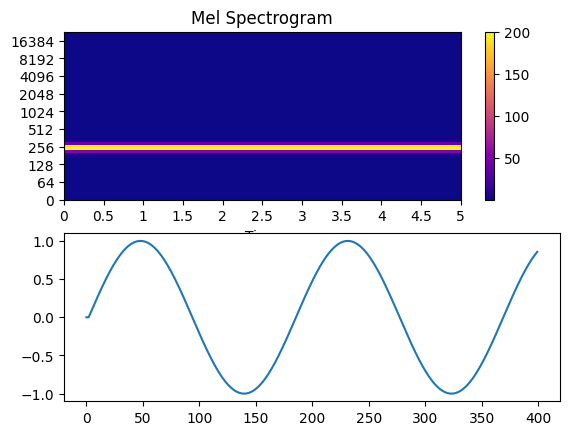

In [8]:
from scipy.stats import entropy

while True:
    graph = get_starting_graph()
    nodes = [SineOscilator, Doubler, ADSR, Sum, Param]

    for _ in range(50):
        random.choice(
            [
                add_random_node,
                add_random_connection,
                add_random_connection,
                remove_random_connection,
                randomize_random_param,
                nudge_random_param,
                randomize_random_param,
                nudge_random_param                
            ]
        )(graph)
    g = graph


    audio_arr = np.zeros(SAMPLE_RATE * 5)

    for node_id, node in graph.nodes.items():
        if isinstance(node, Output):
            output = node_id

    for i in range(len(audio_arr)):
        audio_arr[i] = (g.nodes[output].inputs.input)
        g.tick()
        # time.sleep(0.01)
        
    audio_arr /= max(audio_arr)

    # print("iter")
    print("sum", sum(audio_arr), np.std(audio_arr))
    if sum(audio_arr) != 0 and np.std(audio_arr) > 0.003:
        break
        
# audio_arr
display(Image(g.draw()))

bft_obj, spec_arr = get_spectrogram(audio_arr)

audio_len = audio_arr.shape[-1]


fig, (ax, ax2) = plt.subplots(2, 1, sharex=False, sharey=False)
img = fill_spec(spec_arr, axes=ax,
          x_coords=bft_obj.x_coords(audio_len),
          y_coords=bft_obj.y_coords(),
          x_axis='time', y_axis='log',
          title='Mel Spectrogram')

fig.colorbar(img, ax=ax)

ax2.plot(audio_arr[:400])
display(Audio(data=audio_arr, rate=SAMPLE_RATE))

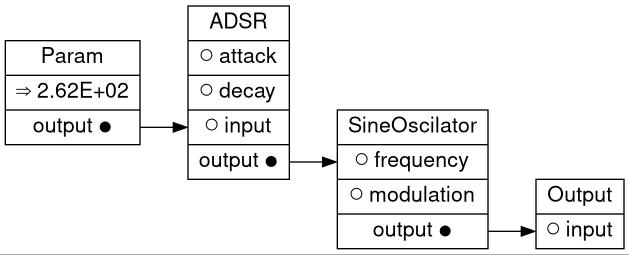

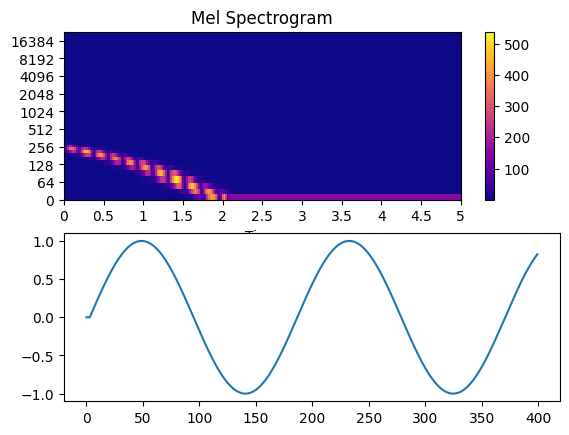

In [12]:
del g
del graph

graph = DspGraph()
sine = graph.add_node(SineOscilator())
p = Param()
p.set_value(BASE_FREQUENCY)
param = graph.add_node(p)
adsr = graph.add_node(ADSR())

output = graph.add_node(Output())


graph.patch(param, "output", adsr, "input")
graph.patch(adsr, "output", sine, "frequency")
graph.patch( sine, "output", output, "input" )
g = graph

display(Image(graph.draw()))


audio_arr = np.zeros(SAMPLE_RATE * 5)

for node_id, node in graph.nodes.items():
    if isinstance(node, Output):
        output = node_id

for i in range(len(audio_arr)):
    audio_arr[i] = (g.nodes[output].inputs.input)
    g.tick()
    # time.sleep(0.01)

# audio_arr /= max(audio_arr)

# print("iter")
# print("sum", sum(audio_arr), np.std(audio_arr))
# if sum(audio_arr) != 0 and np.std(audio_arr) > 0.003:
#     break


bft_obj, spec_arr = get_spectrogram(audio_arr)

audio_len = audio_arr.shape[-1]


fig, (ax, ax2) = plt.subplots(2, 1, sharex=False, sharey=False)
img = fill_spec(spec_arr, axes=ax,
          x_coords=bft_obj.x_coords(audio_len),
          y_coords=bft_obj.y_coords(),
          x_axis='time', y_axis='log',
          title='Mel Spectrogram')

fig.colorbar(img, ax=ax)

ax2.plot(audio_arr[:400])
display(Audio(data=audio_arr, rate=SAMPLE_RATE))

In [13]:
import librosa

y1, sr1 = librosa.load('/home/wint3rmute/code/rust/libretakt/samples/bass_5th.wav') 
y2, sr2 = librosa.load('/home/wint3rmute/code/rust/libretakt/samples/tomll.wav') 


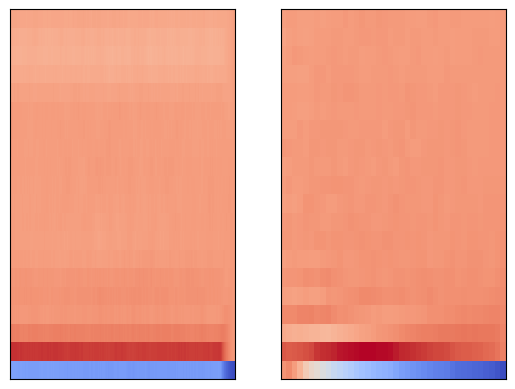

In [21]:
plt.subplot(1, 2, 1)
mfcc1 = librosa.feature.mfcc(y=y1, sr=sr1)
librosa.display.specshow(mfcc1)

plt.subplot(1, 2, 2)
mfcc2 = librosa.feature.mfcc(y=y2, sr=sr2)
librosa.display.specshow(mfcc2)

display(Audio(data=y1, rate=sr1))
Audio(data=y2, rate=sr2)

In [22]:
from dtw import dtw
from numpy.linalg import norm

In [23]:
dist, cost, acc_cost, path = dtw(mfcc1.T, mfcc2.T, dist=lambda x, y: norm(x - y, ord=1))
print('Normalized distance between the two sounds:', dist)

Normalized distance between the two sounds: 161246.11004638672


(-0.5, 39.5)

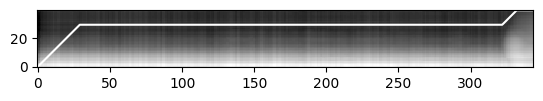

In [27]:
plt.imshow(cost.T, origin='lower', cmap=plt.cm.gray, interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlim((-0.5, cost.shape[0]-0.5))
plt.ylim((-0.5, cost.shape[1]-0.5))